In this notebook, I show how to fine-tune a NLLB-200 machine translation model for a new language.

The new language will be [Tyvan](https://en.wikipedia.org/wiki/Tuvan_language), and I will use a Tyvan-Russian parallel corpus as the training data.

I am running this notebook on Google Colab with a T4 GPU that has 15Gb of memory. If you run it elsewhere, you may want to adjust the batch size, so that there are no OOM errors, but the GPU is well utilized.

# 0. Preliminaries

I run this notebook in Google Colab (which is ephemeral), and to read the dataset and to write the resulting model I use Google Drive, which I mount in the cell below.

In [ ]:
from google.colab import drive
import os
if not os.path.exists('/gd'):
    drive.mount('/gd')

Mounted at /gd


Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [ ]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [ ]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 58.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00


# 1. Exploring the data

In this section, I try to understand what is the training data that I have, and how suitable it is for fine-tuning a NLLB model.

In [ ]:
import pandas as pd

In [ ]:

trans_df = pd.read_csv('/gd/MyDrive/datasets/nlp/tyvan/rus_tyv_parallel_50k.tsv', sep="\t")
print(trans_df.shape)
print(trans_df.columns)

(50000, 5)
Index(['row_id', 'ind', 'tyv', 'ru', 'split'], dtype='object')


In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
trans_df.sample(10)

,row_id,ind,tyv,ru,split
31868,37750,37768,күжениишкинниг ажылдаар,напряжённо работать,train
20431,25217,25233,албан шугуму-биле чалалга,официальное приглашение,train
680,32560,32576,тулчуушкунга белеткенир,подготовиться к бою,train
22889,3839,3853,Ак баштыг ашак,Седой старик,train
19150,13589,13604,далай деңнелинден бедии,высота на уровнем моря,train
13938,17092,17107,демир-орук албаны,служба пути,train
47753,38833,38851,хей чүве чулчуруур,нести чепуху,train
47731,10760,10775,чык долу,битком набитый,train
22662,6094,6109,боос кыс иви,стельная важенка,train
15418,29820,29836,кончуг берге байдалдар,ужасы,train


In [ ]:
trans_df.isnull().sum()

row_id    0
ind       0
tyv       0
ru        0
split     0
dtype: int64

In [ ]:
trans_df.split.value_counts()

train    49000
test       500
dev        500
Name: split, dtype: int64

In [ ]:
df_train = trans_df[trans_df.split=='train'].copy() # 49000 items
df_dev = trans_df[trans_df.split=='dev'].copy()     # 500 items
df_test = trans_df[trans_df.split=='test'].copy()   # 500 items

# 2. How well does the data fit into a NLLB tokenizer?

In [ ]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [ ]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

(…)00M/resolve/main/special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

(…)-600M/resolve/main/tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [ ]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [ ]:
smpl = df_train.sample(10000, random_state=1)

smpl['rus_toks'] = smpl.ru.apply(tokenizer.tokenize)
smpl['tyv_toks'] = smpl.tyv.apply(tokenizer.tokenize)

smpl['rus_words'] = smpl.ru.apply(word_tokenize)
smpl['tyv_words'] = smpl.tyv.apply(word_tokenize)

In [ ]:
smpl.sample(5)[['tyv', 'tyv_words', 'tyv_toks', 'ru', 'rus_words', 'rus_toks']]

,tyv,tyv_words,tyv_toks,ru,rus_words,rus_toks
20899,ооӊ шугулдаары эгелээн,"[ооӊ, шугулдаары, эгелээн]","[▁оо, ӊ, ▁шу, гу, лда, ары, ▁э, гел, ээн]",у неё началась истерика,"[у, неё, началась, истерика]","[▁у, ▁неё, ▁нача, лась, ▁исте, ри, ка]"
48344,чаа нарыыдаашкыннарга таваржыр,"[чаа, нарыыдаашкыннарга, таваржыр]","[▁ча, а, ▁нары, ы, даа, ш, кын, нарга, ▁та, вар, жы, р]",встретиться с новыми осложнениями,"[встретиться, с, новыми, осложнениями]","[▁встре, титься, ▁с, ▁но, выми, ▁ос, лож, нения, ми]"
35267,эрги костюм,"[эрги, костюм]","[▁эр, ги, ▁костю, м]",ношеный костюм,"[ношеный, костюм]","[▁но, шен, ый, ▁костю, м]"
43876,ооң ындыг чоруун канчаар көрдүңер,"[ооң, ындыг, чоруун, канчаар, көрдүңер]","[▁оо, ң, ▁ын, дыг, ▁чо, ру, ун, ▁канча, ар, ▁көр, дү, ңер]",как вы расценили его поступок,"[как, вы, расценили, его, поступок]","[▁как, ▁вы, ▁рас, цени, ли, ▁его, ▁посту, пок]"
18176,мегезин тудары,"[мегезин, тудары]","[▁ме, ге, зин, ▁ту, дары]",уличение во лжи,"[уличение, во, лжи]","[▁ули, чение, ▁во, ▁л, жи]"


In [ ]:
stats = smpl[['rus_toks', 'tyv_toks', 'rus_words', 'tyv_words']].applymap(len).describe()
stats

,rus_toks,tyv_toks,rus_words,tyv_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.124100,6.825800,2.518100,2.816600
std,3.794672,5.307737,2.338294,2.443801
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,2.000000,2.000000
50%,5.000000,6.000000,2.000000,2.000000
75%,6.000000,8.000000,3.000000,3.000000
max,166.000000,180.000000,121.000000,105.000000


In [ ]:
print(stats.rus_toks['mean'] / stats.rus_words['mean'])
print(stats.tyv_toks['mean'] / stats.tyv_words['mean'])

2.034907271355387
2.423418305758716


In [ ]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


Good news: both for Russian and Tyvan, the NLLB tokenizer seems to produce around 2 tokens per word (more precisely, 2.3 and 1.8), which means that the translation quality of fine-tuned NLLB may be decent even without vocabulary extension.

One more check: how often does the <unk> token happen in the tokenizer output for Tyvan? If this is too often, we need to fix it somehow

In [ ]:
texts_with_unk = [text for text in tqdm(trans_df.tyv) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/50000 [00:00<?, ?it/s]

163


In [ ]:
import random
s = random.sample(texts_with_unk, 5)
s

['Ынча деп турар болзуңза, сени кандыг далайжы дээрил?! – деп, Дриниан удурланган.',
 'Ыяштап чоруй барган ачам келгеш, мени аажок мактаар боор: «Ёзулуг аңчы-дыр сен, оглум!»',
 'Ажыл хуваарга — арыг кирер, ажык хуваарга — куруг үнер',
 'Баш бурунгаар дугуржуушкуннар бар – чижээлээрге, кожавыс Моол-биле.',
 'Угааныңарны – ооң анаа, шаптык кадар сеткил сагыш хайныышкыннары долган илерээшкинин энерел сеткил сорук киирген арыг мерген угаан-биле – солууру.']

Apparently, most of the texts with 3634 unknown tokens just have some punctuation unfamiliar to the NLLB tokenizer.

This is because the NLLB model was pretrained on normalized texts. If we reproduce the normalization, most of the problems would be fixed.

In [ ]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/163 [00:00<?, ?it/s]

0


Indeed, after normalizing texts, none of them contain unknown tokens. We will use this as one more piece of evidence that we don't have to update the tokenizer vocabulary to use it with Tyvan.

# 3 (optional). Expanding the vocabulary

# 4. Adding a new language tag to the tokenizer and model

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [ ]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
fix_tokenizer(tokenizer)

In [ ]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'tyv_Cyrl', '<mask>']
[256202, 256203, 256204]


In [ ]:
added_token_id = tokenizer.convert_tokens_to_ids('tyv_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [ ]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# 5. Preparing the training loop

In [ ]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [ ]:
model.cuda();

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [ ]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [ ]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [ ]:
LANGS = [('ru', 'rus_Cyrl'), ('tyv', 'tyv_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))
# (['чеди'], ['семь'], 'tyv_Cyrl', 'rus_Cyrl')

(['чеди'], ['семь'], 'tyv_Cyrl', 'rus_Cyrl')

In [ ]:
MODEL_SAVE_PATH = '/gd/MyDrive/models/nllb-rus-tyv-v1'

# 6. The training loop

In [ ]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/58603 [00:00<?, ?it/s]

42000 0.8175856148898601
43000 0.8200985782444478
44000 0.7894728828966617
45000 0.7737534437477589
46000 0.7595602235496044
47000 0.7579023195952177
48000 0.751591611251235
49000 0.7432025651484728
50000 0.7358342538923025
51000 0.71877786244452
52000 0.7055696906894445
53000 0.7045190439224244
54000 0.6994042806178331
55000 0.6846667068302631
56000 0.674226920068264
57000 0.6710639676004648


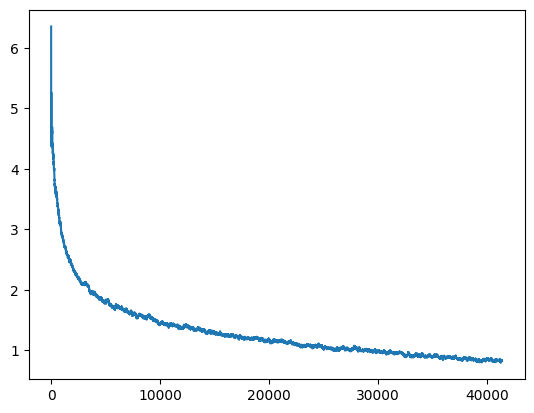

In [ ]:
pd.Series(losses).ewm(100).mean().plot();

In [ ]:
def translate(text, src_lang='rus_Cyrl', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['бир-ле черден соок үрүп тур']
['откуда-то несёт холодом']
['откуда-то дует холод']


In [ ]:
!ls -alsh $MODEL_SAVE_PATH

total 2.3G
1.0K -rw------- 1 root root  896 Sep 30 07:40 config.json
 512 -rw------- 1 root root  184 Sep 30 07:40 generation_config.json
2.3G -rw------- 1 root root 2.3G Sep 30 07:41 pytorch_model.bin
4.7M -rw------- 1 root root 4.7M Sep 30 07:41 sentencepiece.bpe.model
3.5K -rw------- 1 root root 3.5K Sep 30 07:41 special_tokens_map.json
1.0K -rw------- 1 root root  570 Sep 30 07:41 tokenizer_config.json


# 6. Using the model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [ ]:
trans_df = pd.read_csv('/gd/MyDrive/datasets/nlp/tyvan/for_translator.csv')
trans_df.dropna(subset=['ru', 'tyv'], inplace=True)
df_train, df_devtest = train_test_split(trans_df, test_size=1000, random_state=1)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=1)

In [ ]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def translate(text, src_lang='rus_Cyrl', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
t = "мөңгүн үр чыткаш карарар"
print(translate(t, 'tyv_Cyrl', 'rus_Cyrl'))
# ['серебро от времени чернеет']

['серебро от времени чернеет']


In [ ]:
translate(t, 'tyv_Cyrl', 'rus_Cyrl', do_sample=True, num_beams=1, temperature=1.5)

['серебро от ходения цвета']

In [ ]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [ ]:
rus_translated = batched_translate(df_dev.tyv, src_lang='tyv_Cyrl', tgt_lang='rus_Cyrl')

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
df_dev['rus_translated'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [ ]:
xx, yy = ['течёт холод'], ['несёт холодом']
print(bleu_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(yy, [xx]))

BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2)
chrF2++ = 36.75
chrF2++ = 42.30


In [ ]:
print(bleu_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 24.14 52.5/30.4/18.9/12.1 (BP = 0.981 ratio = 0.981 hyp_len = 2281 ref_len = 2324)
chrF2++ = 49.49
BLEU = 23.41 52.1/31.0/18.9/11.3 (BP = 0.966 ratio = 0.967 hyp_len = 2292 ref_len = 2371)
chrF2++ = 50.89


In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
df_dev.sample(10, random_state=5)[['tyv', 'ru', 'tyv_translated', 'rus_translated']]

,tyv,ru,tyv_translated,rus_translated
row_id,,,,
37635,ыяк сактып алыр,намотать на ус,аксынга өттүрер,твёрдо запомнить
42465,чиик үлетпүр,лёгкая промышленность,чиик үлетпүр,лёгкая промышленность
27916,аяк бусту берген,чашка разбилась,аяк бусту берген,чашка лопнула
78401,оларны маш-салатче салыр,выложить их на маш-салат,оларны маш-салатче салыр,выложить их в маш-салат
74168,соус хоюг кылдыр хайынмаан шаанда,пока соус не заварится густо,соус хоюг хайынмаан шаанда,пока соус не сварится густо
61972,шиви,ель,шиви,еловая кобыла
8377,соондан арай боорда шимчээр,тащиться вслед,соондан чүткүүр,еле двинуться вслед
109242,АКШ,США,АКШ,США
38832,бир-ле черден соок үрүп тур,откуда-то несёт холодом,бир-ле черден соок аппар чыдыр,откуда-то течёт холод


In [ ]:
print((df_dev.ru == df_dev.rus_translated).mean())
print((df_dev.tyv == df_dev.tyv_translated).mean())

0.26
0.25


In [ ]:
!pip install editdistance

In [ ]:
import editdistance

def ed_similarity(text1, text2):
    return max(0, 1 - editdistance.eval(text1, text2) / min(len(text1), len(text2)))

print(ed_similarity('кот', 'собака'))
print(ed_similarity('кот', 'кит'))

0
0.6666666666666667


In [ ]:
pd.Series([ed_similarity(row.ru, row.rus_translated) for row in df_dev.itertuples()]).describe()

count    500.000000
mean       0.516367
std        0.392761
min        0.000000
25%        0.116013
50%        0.507009
75%        1.000000
max        1.000000
dtype: float64

In [ ]:
pd.Series([ed_similarity(row.tyv, row.tyv_translated) for row in df_dev.itertuples()]).describe()

count    500.000000
mean       0.506007
std        0.382357
min        0.000000
25%        0.111111
50%        0.504902
75%        0.979730
max        1.000000
dtype: float64

In [ ]:
df_dev.index.name = "row_id"

In [ ]:
df_dev.to_csv(model_load_name + "/dev_set_translated.tsv", sep="\t")

Evaluating another model (with extended vocabulary)

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc'

In [ ]:
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name + "/pytorch_model_60k.bin", config=cfg).cuda()

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
df_dev['rus_translated2'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
df_dev['tyv_translated2'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print(bleu_calc.corpus_score(df_dev['rus_translated2'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated2'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated2'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated2'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 25.18 52.4/31.3/20.4/13.3 (BP = 0.976 ratio = 0.976 hyp_len = 2269 ref_len = 2324)
chrF2++ = 49.85
BLEU = 23.22 51.6/29.4/18.3/11.6 (BP = 0.975 ratio = 0.975 hyp_len = 2312 ref_len = 2371)
chrF2++ = 49.87


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()

In [ ]:
df_dev['rus_translated3'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated3'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print(bleu_calc.corpus_score(df_dev['rus_translated3'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated3'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated3'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated3'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 23.06 51.1/29.1/18.1/11.5 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 48.56
BLEU = 26.12 53.4/32.5/21.0/13.6 (BP = 0.985 ratio = 0.985 hyp_len = 2336 ref_len = 2371)
chrF2++ = 52.60


In [ ]:
df_dev['rus2eng'] = [translate(t, 'tyv_Cyrl', 'eng_Latn')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv2eng'] = [translate(t, 'rus_Cyrl', 'eng_Latn')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Results with num_beams=1:
```
V1
BLEU = 23.21 51.2/29.1/18.0/11.8 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 47.88
BLEU = 22.03 51.5/29.7/17.9/10.4 (BP = 0.952 ratio = 0.953 hyp_len = 2260 ref_len = 2371)
chrF2++ = 49.37
V2
BLEU = 24.08 50.9/29.5/19.1/12.3 (BP = 0.988 ratio = 0.988 hyp_len = 2297 ref_len = 2324)
chrF2++ = 48.96
BLEU = 22.50 50.5/28.5/17.7/11.1 (BP = 0.974 ratio = 0.974 hyp_len = 2310 ref_len = 2371)
chrF2++ = 48.85
V3
BLEU = 22.25 49.8/27.8/17.2/11.0 (BP = 0.983 ratio = 0.983 hyp_len = 2284 ref_len = 2324)
chrF2++ = 47.89
BLEU = 25.28 52.2/31.2/20.0/13.1 (BP = 0.989 ratio = 0.989 hyp_len = 2346 ref_len = 2371)
chrF2++ = 51.87
````

Results with 4 beams:
```
V1
BLEU = 24.14 52.5/30.4/18.9/12.1 (BP = 0.981 ratio = 0.981 hyp_len = 2281 ref_len = 2324)
chrF2++ = 49.49
BLEU = 23.41 52.1/31.0/18.9/11.3 (BP = 0.966 ratio = 0.967 hyp_len = 2292 ref_len = 2371)
chrF2++ = 50.89
V2
BLEU = 25.18 52.4/31.3/20.4/13.3 (BP = 0.976 ratio = 0.976 hyp_len = 2269 ref_len = 2324)
chrF2++ = 49.85
BLEU = 23.22 51.6/29.4/18.3/11.6 (BP = 0.975 ratio = 0.975 hyp_len = 2312 ref_len = 2371)
chrF2++ = 49.87
V3
BLEU = 23.06 51.1/29.1/18.1/11.5 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 48.56
BLEU = 26.12 53.4/32.5/21.0/13.6 (BP = 0.985 ratio = 0.985 hyp_len = 2336 ref_len = 2371)
chrF2++ = 52.60
```

Which means:
* For all directions and models, beam search improves the results
* Longer training builds up quality for Tyvan, but decreases it for Russian.

```
                                  | tyv->rus | rus->tyv
Model v1 (no vocabulary update):  |
    no beam search                |   23.21  |  22.03
    num_beams = 4                 |   24.14  |  23.41
Model v2 (with vocabulary update):|
    no beam search                |   24.08  |  22.50
    num_beams = 4                 |   25.18  |  23.22
```

In [ ]:
df_dev.to_csv(model_load_name + "/dev_set_translated.tsv", sep="\t")

Here are some examples of how translation has changed:

In [ ]:
df_dev.sample(5, random_state=1)[['tyv', 'ru', 'rus_translated']]

,tyv,ru,rus_translated
row_id,,,
5442,транспорт херекселдерин ажыглаарының база шимчээшкинниң айыыл чок чоруунуң дүрүмнери,правила безопасности движения и эксплуатации транспортных средств,правила безопасности движения и эксплуатации транспортных средств
57777,аъш-чем садыы,продовольственный магазин,продовольственный магазин
104130,"Бүгү чүве төнген, бойлаан.","Все было кончено, потеряно.","Все было кончено, самостоятельно."
49344,фокуска кирбес,не попасть в фокус,не попасть в фокус
28319,рекорд тургузар,установить рекорд,поставить рекорд


In [ ]:
df_dev.sample(20, random_state=1)[[
    'tyv', 'tyv_translated', 'tyv_translated2', 'tyv_translated3', 'tyv2eng',
    'ru', 'rus_translated', 'rus_translated2', 'rus_translated3', 'rus2eng',
]]

,tyv,tyv_translated,tyv_translated2,tyv_translated3,tyv2eng,ru,rus_translated,rus_translated2,rus_translated3,rus2eng
row_id,,,,,,,,,,
5442,транспорт херекселдерин ажыглаарының база шимчээшкинниң айыыл чок чоруунуң дүрүмнери,шимчээшкинниң болгаш транспорт аймаан ажыглаарының айыыл чок чоруунуң дүрүмнери,транспорт аймаан шимчээшкининиң болгаш ажыглаарының айыыл чок чоруунуң дүрүмнери,транспорт аймаан шимчээшкининиң болгаш транспорт аймаан ажыглаарының айыыл чок чоруунуң дүрүмнери,ң болгаш транспорт аймаан ажыглаарының айыыл чок чоруунуң дүрүмнери,правила безопасности движения и эксплуатации транспортных средств,правила безопасности движения и эксплуатации транспортных средств,правила эксплуатации транспортных средств и безопасности движения,правила безопасности эксплуатации транспортных средств и движения,дүрүмнер транспорт херекселдерин ажыглаарының болгаш шимчээшкинниң айыыл чок чоруунуң дугайында
57777,аъш-чем садыы,аъш-чем садыы,аъш-чем садыы,аъш-чем садыы,садыы,продовольственный магазин,продовольственный магазин,продовольственный магазин,продовольственный магазин,садыы
104130,"Бүгү чүве төнген, бойлаан.","Шупту чүве доозулган, читкен.","Шупту чүве төнген, читкен.","Бүгү чүве бойлаан, читкен.","-даа, читкен-даа.","Все было кончено, потеряно.","Все было кончено, самостоятельно.","Все кончилось, разошёлся.","Все кончено, кончено.","-ла, бүгү чүве кончилось."
49344,фокуска кирбес,илби-шидиге алзыр арга чок,илбиге алыспас,илби-шидиге туттурбас,гге күш четпес,не попасть в фокус,не попасть в фокус,не попасться в фокусы,не попасть на фокус,г
28319,рекорд тургузар,рекорд тургузар,рекорд тургузар,рекорд тургузар,г тургузар,установить рекорд,поставить рекорд,установить рекорд,установить рекорд,г тургузар
43534,чурукту делгээр,чурукту делгээр,чурук делгээр,чурукту делгээр,ң чурукту делгээр,выставлять картину,выставлять картину,развернуть картину,экспонировать картину,чурукту делгередип чуруур
37159,ылап хөделир,ылап хөделир,бүзүрелдиг хөделир,ылап хөделир,г хөделир,действовать наверняка,действовать аккуратно,действовать наверняка,действовать наверняка,г хөделир
36993,колдуктап алгаш чоруур,шыңганның адаанга көдүрүп алгаш чоруур,колдук адаанга аппаар,колдуктап алгаш чоруур,г шыгжаар,нести под мышкой,нести под мышками,носить под мышкой,нести под мышкой,алгаш чоруур
116009,Копривничко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,чко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,вничко-Крижевачка


In [ ]:
cols = ['ind', 'tyv', 'ru']
splits = {'train': df_train[df_train.index<=49_454], 'test': df_test, 'dev': df_dev}
df_joint = []
for k, v in splits.items():
    v = v[cols].copy()
    v.index.name = "row_id"
    v['split'] = k
    df_joint.append(v)
df_joint = pd.concat(df_joint)
df_joint.shape

(50000, 4)

In [ ]:
df_joint.sample(5)

,ind,tyv,ru,split
row_id,,,,
314,328,Өг-бүле бүрүзү эвээш дээрге-ле 500-600 ивини азырап өстүрзүн.,Пусть на каждую семью было хотя бы по 500-600 оленей.,train
4376,4390,Өрээл аяннаны берген,Комната приняла хороший вид,train
13377,13392,кым-бир кижи-биле силер деп чугаалажыр,быть на вы с кем-либо,train
91144,97279,"Идээледир чемнениринде база эки чүү-даа чүве чок, ынчангаш арай эвээшти чиңер.","Ничего хорошего нет и в переедании, так что ешьте поменьше.",dev
307,321,"Оларның аразында 14 суурда 500 четпес, а 8 суурда 250 хире чурттакчы бар.","Среди них в 14 селах менее 500, в восьми - менее 250 человек.",train


In [ ]:
df_joint.to_csv("/gd/MyDrive/datasets/nlp/tyvan/rus_tyv_parallel_50k.tsv", sep="\t")

# Publishing the model to HF

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Your token has been saved in your

In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
upload_repo = "slone/nllb-rus-tyv-v1"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/slone/nllb-rus-tyv-v1/commit/e45e25aa62c8487aaa7050d804f9851ae01e353a', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='e45e25aa62c8487aaa7050d804f9851ae01e353a', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc'
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name + "/pytorch_model_60k.bin", config=cfg)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
upload_repo = "slone/nllb-rus-tyv-v2-extvoc"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/slone/nllb-rus-tyv-v2-extvoc/commit/48e9b1269b037fe08280bfec990c189e5748bccd', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='48e9b1269b037fe08280bfec990c189e5748bccd', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', '<mask>', 'tyv_Cyrl']
[256202, 256204, 256203]


Testing that it works

In [ ]:
MODEL_URL = 'slone/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
tokenizer = NllbTokenizer.from_pretrained(MODEL_URL, force_download=True)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='rus_Cyrl',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out

In [ ]:
translate("красная птица", model=model, tokenizer=tokenizer)

'кызыл куш'

In [ ]:
translate("красная птица", model=model, tokenizer=tokenizer, tgt_lang='eng_Latn')

': кызыл куш'

In [ ]:
lang_to_code = {
    'Русский | Russian': 'rus_Cyrl',
    'Тувинский | Tyvan': 'tyv_Cyrl',
}

In [ ]:
def translate_wrapper(text, src, trg, correct=None):
    src_lang = lang_to_code.get(src)
    tgt_lang = lang_to_code.get(trg)
    if src == trg:
        return 'Please choose two different languages'
    print(text, src, trg)
    result = translate(
        text=text,
        model=model,
        tokenizer=tokenizer,
        src_lang=src_lang,
        tgt_lang=tgt_lang,
    )
    return result

In [ ]:
translate_wrapper("красная птица", 'Русский | Russian', 'Тувинский | Tyvan')

красная птица Русский | Russian Тувинский | Tyvan


'кызыл куш'